# CKA Similarity Analysis
In this notebook we explore the CKA similarity metric with quantized models.

In [10]:
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean
import warnings
import pygwalker as pyg


# import modules from JTAG model
module_path = os.path.abspath(os.path.join('../../workspace/models/jets/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import model as jet_tagger
import jet_datamodule

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import q_autoencoder as econ
import autoencoder_datamodule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from CKA import CKA



## Utility methods

In [11]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()

In [12]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
cka_batch_num = 50000

# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [13]:
DATA_PATH = '/home/jovyan/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'
ECON_layers = ['encoder.conv', 'encoder.enc_dense']

precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]

In [14]:
def get_cka_per_model(batch_size, 
                      learning_rate, 
                      precision, 
                      size,
                      dataloader,
                      activation_layers=ECON_layers,
                      max_batches=cka_batch_num):
    # load the model
    model, _ = econ.load_model(DATA_PATH, batch_size, learning_rate, precision, size)
    
    # init the metric
    cka = CKA(model, 
              dataloader, 
              layers=activation_layers,
              max_batches=max_batches)
    
    return cka


def compute_distance(cka, batch_size, learning_rate, precision, size, load=True):
    # check if distance already computed
    if load:
        cka.name = f'distance_{size}_bs{batch_size}_lr{learning_rate}_p{precision}'
        if cka.load_from_file(DATA_PATH):
            return cka.results
        
    model, _ = econ.load_model(DATA_PATH, batch_size, learning_rate, precision, size)
    # compute the difference
    result = cka.compare(model, cka.layers)
    cka.save_on_file(path=DATA_PATH)
    
    return result

## Result

In [15]:
# During the computation of the CKA similarity both the model must process the same data, 
# so we create a cka_dataloader equal for all the models which we will use to carry on our
# test
data_module = autoencoder_datamodule.get_data_module(DATASET_DIR, DATASET_FILE, 16)
cka_dataloader = data_module.test_dataloader()
noise_type = 'gaussian'
noise = 5 # 5 10 15 20

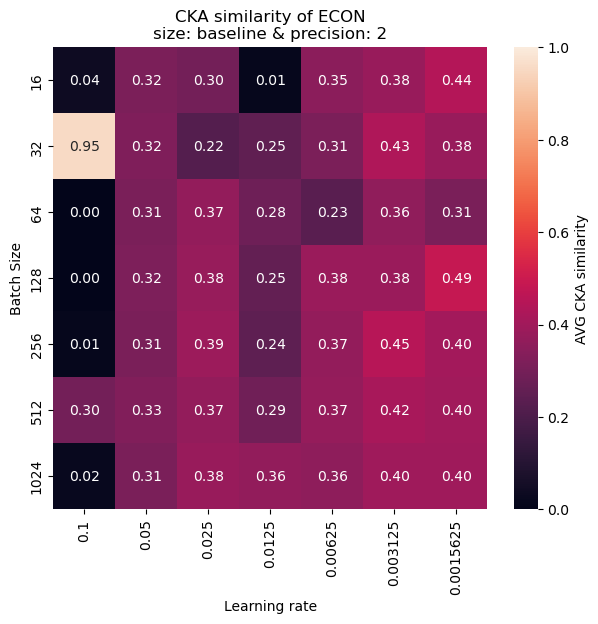

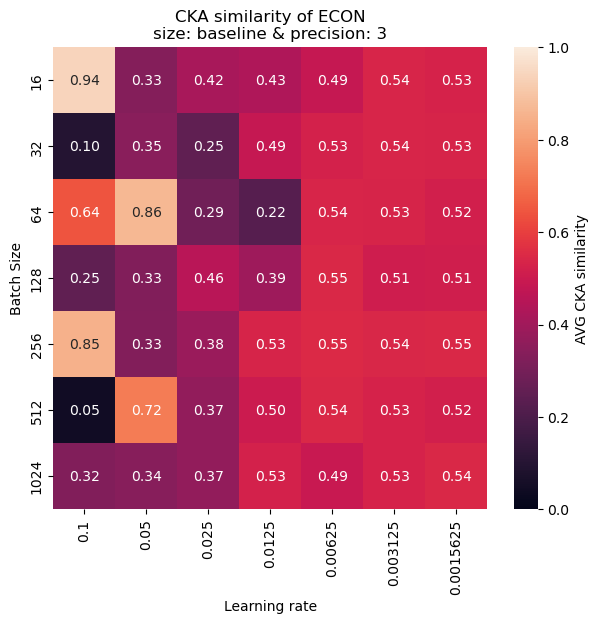

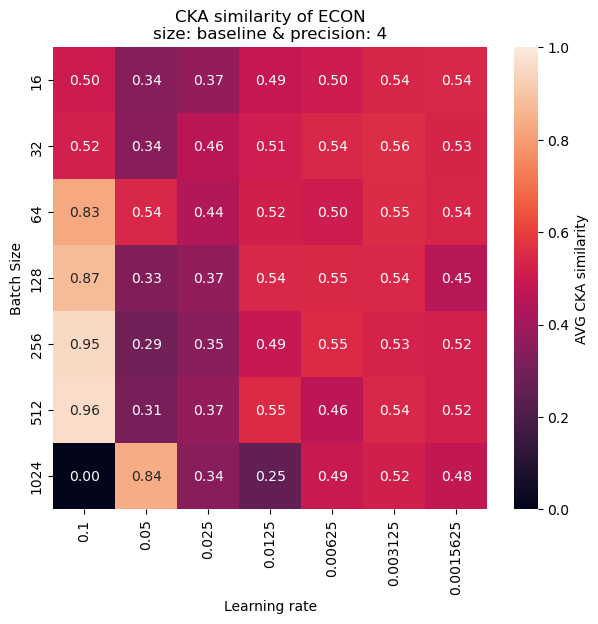

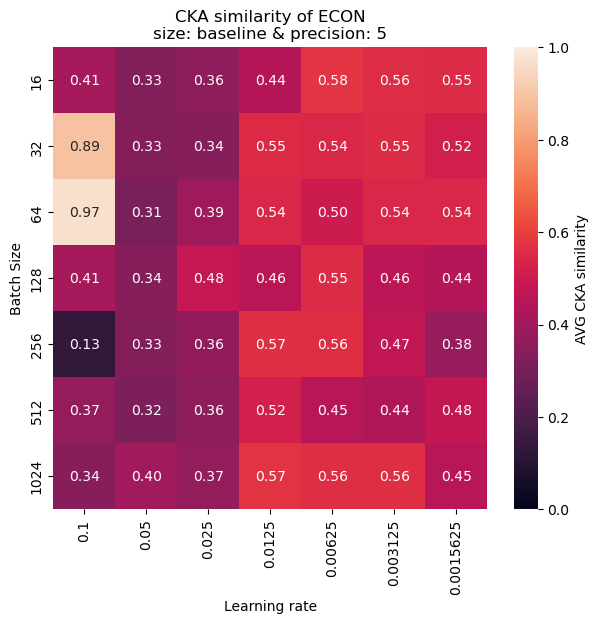

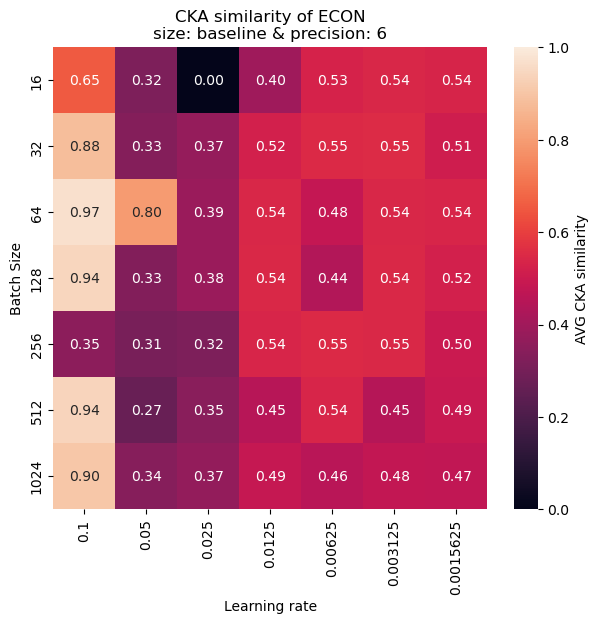

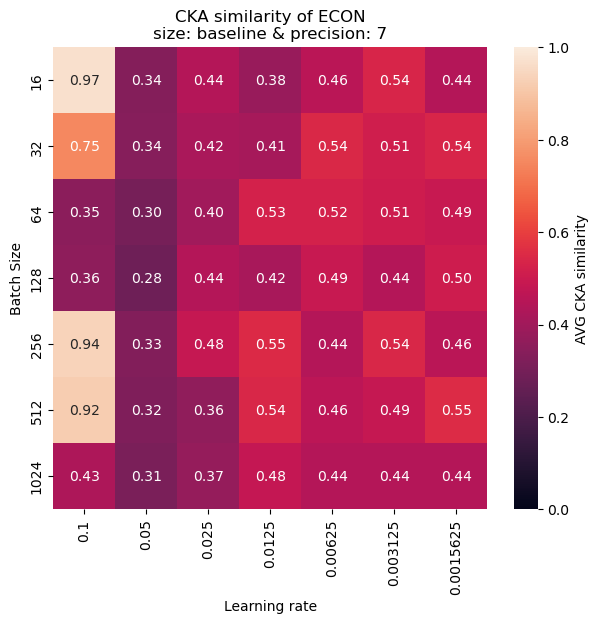

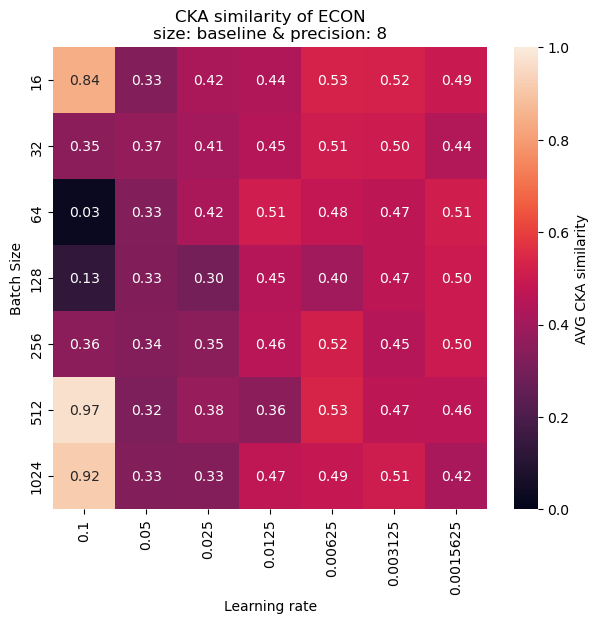

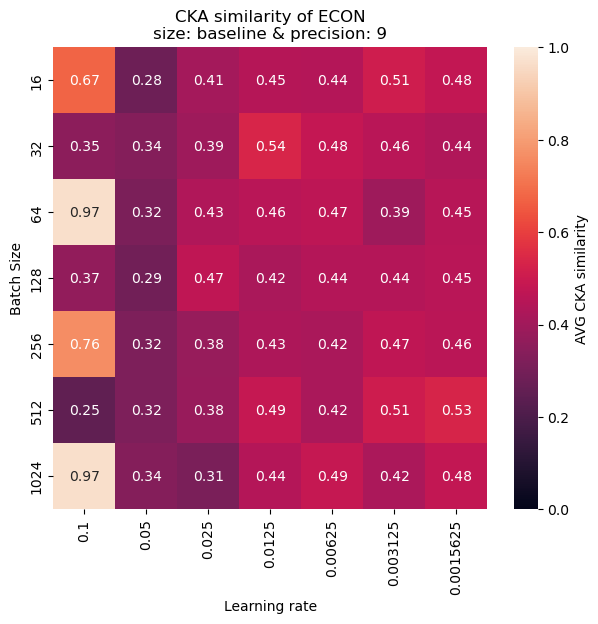

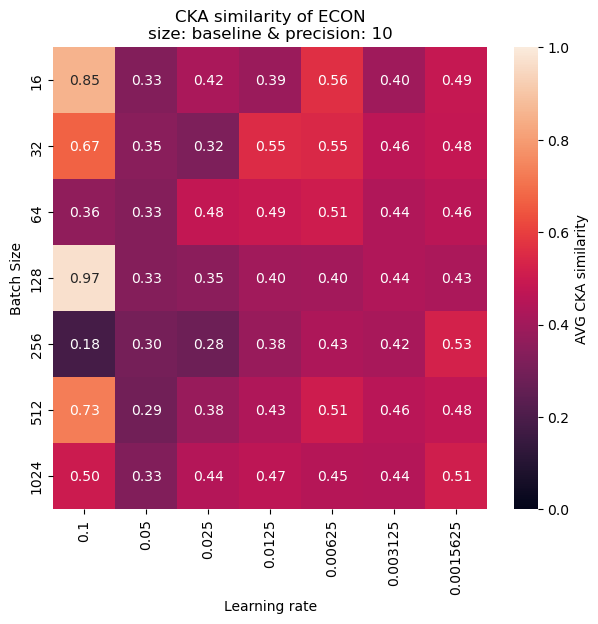

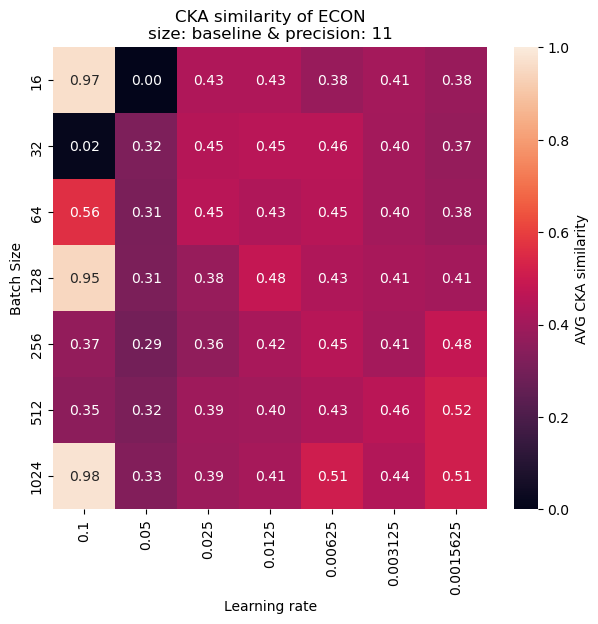

In [18]:
cka_distribution = []
for p in precisions:
    CKA_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # get the performance of the model with and without noise
            mean_emd, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            noise_emd = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, noise)
            # path to the directory
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_{p}b/{size}/')
            # get the metric
            cka = get_cka_per_model(bs,
                                    lr,
                                    p,
                                    size,
                                    cka_dataloader,
                                    ECON_layers,
                                    max_batches=cka_batch_num)
            
            # load the results
            avg_cka = -1
            if cka.load_from_file(path):
                avg_cka = cka.results['CKA_similarity']
                

            # build the heatmap
            CKA_matrix[x, y] = avg_cka
            
            # build the dataframe for further analysis
            cka_distribution.append({
                'precision': p, 
                'avg_cka': avg_cka,
                'emd': mean_emd,
                'noise_emd': noise_emd,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (noise_emd - mean_emd) * 100 / mean_emd,
            })
            
            
    CKA_matrix = pd.DataFrame(CKA_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    plot_2d_heatmap(CKA_matrix, 
                    f'CKA similarity of ECON\nsize: {size} & precision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'AVG CKA similarity',
                    cmap='rocket')

In [19]:
cka_distribution_df = pd.DataFrame(cka_distribution)
# export as CSV
cka_distribution_df.to_csv('./results/econ/cka.csv', index=False)

In [ ]:
cka = get_cka_per_model(256, 0.00625, 8, 'baseline', cka_dataloader, ECON_layers)

model, _ = econ.load_model(DATA_PATH, 256, 0.00625, 8, 'baseline')

print(cka.compare_output(model))

# Jet Tagger (MLP)
The full precision model achieve 76% of accuracy.

In [ ]:
DATA_PATH = "/home/jovyan/checkpoint/"    
DATASET_DIR = "../../data/JTAG"
DATASET_FILE = DATASET_DIR + "/processed_dataset.h5"

JTAG_layers = ['model.dense_1', 'model.dense_2', 'model.dense_3', 'model.dense_4']
# we do not consider extreme low precisions due to their performances
precisions = [4, 5, 6, 7, 8, 9, 10, 11]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]

In [ ]:
def get_cka_per_model(batch_size, 
                      learning_rate, 
                      precision, 
                      dataloader,
                      activation_layers=ECON_layers,
                      max_batches=cka_batch_num):
    # load the model
    model, _ = jet_tagger.load_model(DATA_PATH, batch_size, learning_rate, precision)
    
    # init the metric
    cka = CKA(model, 
              dataloader, 
              layers=activation_layers,
              max_batches=max_batches)
    
    return cka


def compute_distance(cka, batch_size, learning_rate, precision, load=True):
    # check if distance already computed
    if load:
        cka.name = f'distance_{size}_bs{batch_size}_lr{learning_rate}_p{precision}'
        if cka.load_from_file(DATA_PATH):
            return cka.results
        
    model, _ = jet_tagger.load_model(DATA_PATH, batch_size, learning_rate, precision)
    # compute the difference
    result = cka.compare(model, cka.layers)
    cka.save_on_file(path=DATA_PATH)
    
    return result

In [ ]:
cka_distribution_df = pd.DataFrame(cka_distribution)

## Per layer analysis

In [ ]:
MAX_LOSS = 50
MIN_ACCURACY = 0.72
NUM_PLOT = 3

cka_distribution_df = cka_distribution_df.loc[
        (cka_distribution_df.loss > -0.5) & 
        (cka_distribution_df.accuracy > MIN_ACCURACY) # &
        # (ne_distribution_df.loss < MAX_LOSS)
    ]
cka_distribution_df.sort_values(by='loss', ascending=True, inplace=True)

In [ ]:
best_df = cka_distribution_df.head(NUM_PLOT)
for i in range(NUM_PLOT):
    print('-'*80)
    print('Low loss')
    
    path = os.path.join(
        DATA_PATH,
        f"bs{best_df.iloc[i]['batch_size']}_lr{best_df.iloc[i]['learning_rate']}" \
        f"/JTAG_{best_df.iloc[i]['precision']}b//"
    )
    cka = get_cka_per_model(int(best_df.iloc[i]['batch_size']),
                            float(best_df.iloc[i]['learning_rate']), 
                            int(best_df.iloc[i]['precision']),
                            cka_dataloader,
                            max_batches=cka_batch_num)
    if cka.load_from_file(path):
        results = cka.results
    else:
        results = cka.compute()
        
    print(f"Accuracy:\t{best_df.iloc[i]['accuracy']}\n" \
          f"Loss:\t{best_df.iloc[i]['loss']}\n" \
          f"AVG CKA similarity:\t{best_df.iloc[i]['avg_cka']}")
    
    plot_2d_heatmap(results['internal_cka'].cpu().detach().numpy(), 
                    f"CKA similarity per layer\n{best_df.iloc[i]}", 
                    scale_label='CKA similarity')


--------------------------------------------------------------------------------
Low loss
File CKA_similarity.pkl not found!


RuntimeError: stack expects a non-empty TensorList

--------------------------------------------------------------------------------
Low loss
accuracy:	0.760420823097229
Loss:	73.5820620453879
AVG CKA similarity:	0.4155755043029785


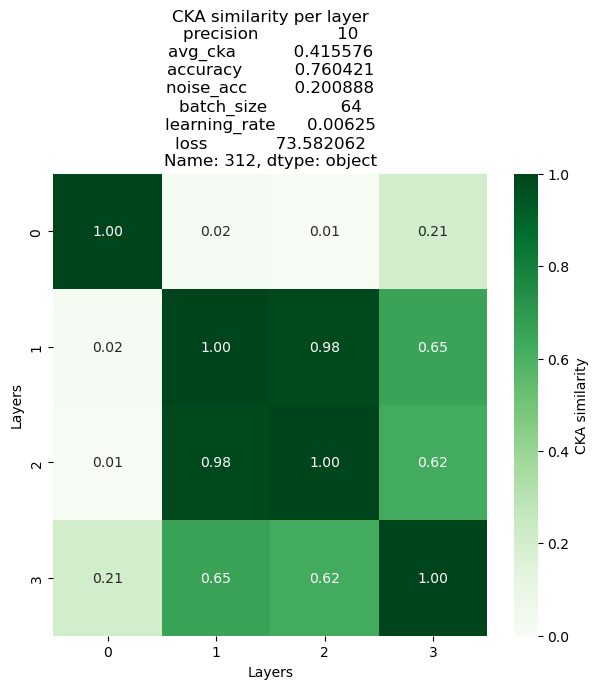

--------------------------------------------------------------------------------
Low loss
accuracy:	0.7595208406448364
Loss:	73.67528917779174
AVG CKA similarity:	0.4776167869567871


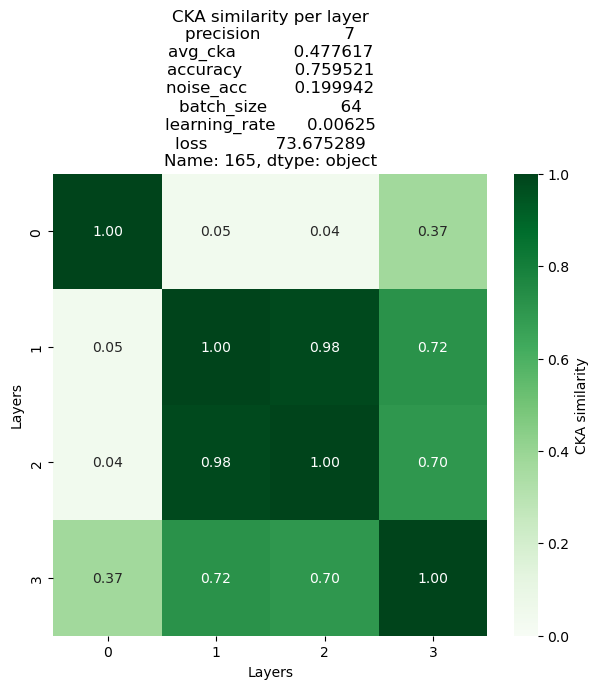

--------------------------------------------------------------------------------
Low loss
accuracy:	0.7611416697502136
Loss:	73.9585267415526
AVG CKA similarity:	0.42878182729085285


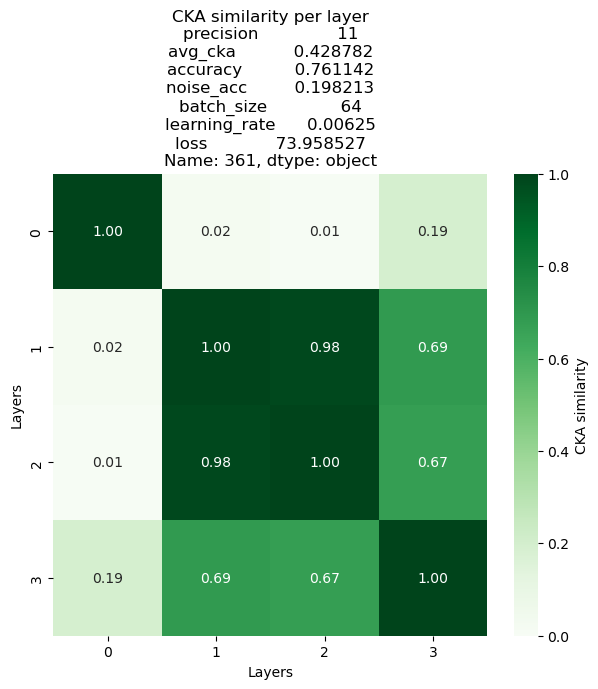

In [ ]:
worst_df = cka_distribution_df.tail(NUM_PLOT)
for i in range(NUM_PLOT):
    print('-'*80)
    print('Low loss')
    
    path = os.path.join(
        DATA_PATH,
        f"bs{worst_df.iloc[i]['batch_size']}_lr{worst_df.iloc[i]['learning_rate']}" \
        f"/JTAG_{worst_df.iloc[i]['precision']}b/"
    )
    cka = get_cka_per_model(int(worst_df.iloc[i]['batch_size']),
                            float(worst_df.iloc[i]['learning_rate']), 
                            int(worst_df.iloc[i]['precision']),
                            cka_dataloader,
                            max_batches=cka_batch_num)
    if cka.load_from_file(path):
        results = cka.results
    else:
        results = cka.compute()
        
    print(f"accuracy:\t{worst_df.iloc[i]['accuracy']}\n" \
          f"Loss:\t{worst_df.iloc[i]['loss']}\n" \
          f"AVG CKA similarity:\t{worst_df.iloc[i]['avg_cka']}")
    
    plot_2d_heatmap(results['internal_cka'].cpu().detach().numpy(), 
                    f"CKA similarity per layer\n{worst_df.iloc[i]}", 
                    scale_label='CKA similarity')

In [ ]:
# TODO: plot the distance in the space